## SIGW with time confounding

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import math
import numpy as np

from coba.experiments  import Experiment, Result
from coba.environments import Environments
from coba.learners     import (RandomLearner,
                               EpsilonBanditLearner,
                               VowpalEpsilonLearner,
                               VowpalRegcbLearner,
                               VowpalSquarecbLearner,
                               LinUCBLearner)

from learners import (IGWBanditLearner,
                      SemiparametricIGWBanditLearner, MNA_SIGWBanditLearner)

## Simulation 1

- Number of arms: 10
- Number of features: 10
- Number of interactions: 10000
- Noise stddev: 1/10
- Contexts are sampled from a unit sphere.
- Arm treatment effects: constant for all arms.
- Nusance reward: Linear.
- Time confounder: sin(t/100)

2022-03-07 15:56:20 -- Processing chunk...
2022-03-07 15:56:20 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-03-07 15:56:20 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-03-07 15:56:20 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-03-07 15:56:20 --   * Recording Learner 3 parameters... (0.0 seconds) (completed)
2022-03-07 15:56:32 --   * Loading LambdaSimulation... (11.29 seconds) (completed)
2022-03-07 15:56:32 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-03-07 15:56:32 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-03-07 15:56:33 --   * Evaluating Learner 0 on Environment 0... (0.86 seconds) (completed)
2022-03-07 15:56:53 --   * Evaluating Learner 1 on Environment 0... (20.64 seconds) (completed)
2022-03-07 15:57:19 --   * Evaluating Learner 2 on Environment 0... (25.55 seconds) (completed)
2022-03-07 15:57:33 --   * Evaluating Learner 3 on

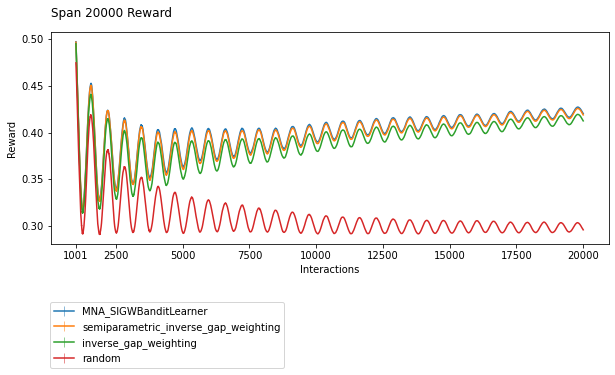

In [18]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 10
n_context_features = 10
n_interactions = 20000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

onehot = np.zeros(n_actions)
onehot[0] = 1

rs = 0.5* (np.random.uniform(size=(n_actions)) + onehot)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
#     context = np.abs(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = np.dot(theta, np.array(context))
        
    h = np.mean(v)
    h += np.sin(index/100)
   
    g = rs[np.argmax(action)]
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    
    return h + g + e
environments = [LambdaSimulation(n_interactions, context, actions, rewards)]

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = False
learners     = [RandomLearner(),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                SemiparametricIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)]

exp_evaluate = Experiment(environments, learners).evaluate()

exp_evaluate.plot_learners(sort="reward", span=n_interactions)